# Blood Usage Prediction

In [19]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from fastai.structured import *
from fastai.column_data import *
import pandas as pd
import time
from dateutil.parser import parse
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 20
import numpy as np
from pandas_summary import DataFrameSummary
from importlib import reload
from ml_utils.structure.viz import *
np.set_printoptions(threshold=50, edgeitems=20)

def summary_df(df):
    display(DataFrameSummary(df).summary())

PATH='./data/'

In [66]:
def concat(L):
    result = None
    for l in L:
        if result is None:
            result = l
        else:
            try:
                result[l.columns.tolist()] = l
            except:
                print(l.head())
    return result
def date_add_days(start_date, days):
    end_date = parse(start_date[:10]) + timedelta(days=days)
    end_date = end_date.strftime('%Y-%m-%d')
    return end_date

def diff_of_days(day1, day2):
    days = (parse(day1[:10]) - parse(day2[:10])).days
    return days

def left_merge(data1, data2, on):
    if type(on) != list:
        on = [on]
    if (set(on) & set(data2.columns)) != set(on):
        data2_temp = data2.reset_index()
    else:
        data2_temp = data2.copy()
    columns = [f for f in data2.columns if f not in on]
    result = data1.merge(data2_temp, on=on, how='left')
    result = result[columns]
    return result

def get_label(end_date, n_day, data_dict):
    """ 
    end_date : end of statistic set
    n_day: the span of label set
    """
    data = data_dict['data']
    date_info = data_dict['date_info']
    label_end_date = date_add_days(end_date, n_day)
    data.DATE = data.DATE.astype('str')
    label = data[(data['DATE'] < label_end_date) &
                 (data['DATE'] >= end_date)].copy()
    label['end_date'] = end_date
    # diff of pivot date and visit date
    # related to weighting
    label['diff_of_day'] = label['DATE'].apply(
        lambda x: diff_of_days(x, end_date))
    label['month'] = label['DATE'].str[5:7].astype(int)
    label['year'] = label['DATE'].str[:4].astype(int)
    # before & after holiday trend
    for i in [3, 2, 1, -1]:
        date_info_temp = date_info.copy()
        date_info_temp['DATE'] = date_info_temp['DATE'].apply(
            lambda x: date_add_days(x, i))
        date_info_temp.rename(columns={'hol3': 'ahead_hol3_{}'.format(
            i), 'hol7': 'ahead_hol7_{}'.format(i), 'holw': 'ahead_holw_{}'.format(i)}, inplace=True)
        label = label.merge(date_info_temp, on=['DATE'], how='left')
    label = label.reset_index(drop=True)
    return label

def get_sta_feat(label, key, n_day, data_dict, var_name, grpby, y):
    data = data_dict['data']
    start_date = date_add_days(key[0], -n_day)
    data_temp = data[(data.DATE < key[0]) & (
        data.DATE > start_date)].copy()
    result = data_temp.groupby(grpby, as_index=False)[y].agg({'{}_min{}'.format(var_name, n_day): 'min',
                                                                              '{}_mean{}'.format(var_name, n_day): 'mean',
                                                                              '{}_median{}'.format(var_name, n_day): 'median',
                                                                              '{}_max{}'.format(var_name, n_day): 'max',
                                                                              '{}_count{}'.format(var_name, n_day): 'count',
                                                                              '{}_std{}'.format(var_name, n_day): 'std',
                                                                              '{}_skew{}'.format(var_name, n_day): 'skew'})
    result = left_merge(label, result, on=grpby).fillna(0)
    return result

def get_scope_feat(label, key, n_day, data_dict):
    grpby = ['SCOPE']
    y = 'UNITS'
    var_name = '_'.join(get_scope_feat.__name__.split('_')[1:-1])
    return get_sta_feat(label, key, n_day, data_dict, var_name, grpby, y)

def get_scope_dow_feat(label, key, n_day, data_dict):
    grpby = ['SCOPE', 'dow']
    y = 'UNITS'
    var_name = '_'.join(get_scope_dow_feat.__name__.split('_')[1:-1])
    return get_sta_feat(label, key, n_day, data_dict, var_name, grpby, y)

def get_grp_feat(label, key, n_day, data_dict):
    grpby = ['BLD_GROUP_CODE']
    y = 'UNITS'
    var_name = '_'.join(get_grp_feat.__name__.split('_')[1:-1])
    return get_sta_feat(label, key, n_day, data_dict, var_name, grpby, y)

def get_grp_dow_feat(label, key, n_day, data_dict):
    grpby = ['BLD_GROUP_CODE', 'dow']
    y = 'UNITS'
    var_name = '_'.join(get_scope_dow_feat.__name__.split('_')[1:-1])
    return get_sta_feat(label, key, n_day, data_dict, var_name, grpby, y)

# second feature
def second_feat(result):
    result['scope_mean_14_28_rate'] = result['scope_mean14']/(result['scope_mean28']+0.01)
    result['scope_mean_28_56_rate'] = result['scope_mean28'] / (result['scope_mean56'] + 0.01)
    result['scope_mean_56_1000_rate'] = result['scope_mean56'] / (result['scope_mean1000'] + 0.01)
    result['grp_mean_28_56_rate'] = result['grp_mean28'] / (result['grp_mean56'] + 0.01)
    result['grp_mean_56_1000_rate'] = result['grp_mean56'] / (result['grp_mean1000'] + 0.01)
    return result

# def get_grp_scope_feat(label, key, n_day, data_dict):
#     grpby = ['BLD_GROUP_CODE', 'SCOPE']
#     y = 'UNITS'
#     var_name = '_'.join(get_grp_dow_feat.__name__.split('_')[1:-1])

#     return get_sta_feat(label, key, n_day, data_dict, var_name, grpby, y)

# def get_grp_dow_scope_feat(label, key, n_day, data_dict):
#     grpby = ['BLD_GROUP_CODE', 'dow', 'SCOPE']
#     y = 'UNITS'
#     var_name = '_'.join(get_grp_dow_feat.__name__.split('_')[1:-1])
#     return get_sta_feat(label, key, n_day, data_dict, var_name, grpby, y)


In [123]:
data_dict = pd.read_pickle(f'{PATH}data_dict')

In [124]:
data_dict['data']['UNITS'] = np.log1p(data_dict['data']['UNITS'])

In [125]:
data = data_dict['data']

In [126]:
summary_df(data)

,BLD_GROUP_CODE,DATE,SCOPE,UNITS,dow,month,year,dom,hol3,hol7,holw
count,20748,NaN,NaN,20748,20748,20748,20748,20748,20748,20748,20748
mean,2.5,NaN,NaN,2.86038,3,6.2782,2014.89,15.6865,0.0416426,0.0364372,0.428571
std,1.11806,NaN,NaN,1.32341,2.00005,3.37344,1.36925,8.78411,0.199776,0.18738,0.494884
min,1,NaN,NaN,0,0,1,2013,1,0,0,0
25%,1.75,NaN,NaN,1.94591,1,3,2014,8,0,0,0
50%,2.5,NaN,NaN,3.2581,3,6,2015,16,0,0,0
75%,3.25,NaN,NaN,3.98898,5,9,2016,23,0,0,1
max,4,NaN,NaN,5.03695,6,12,2017,31,1,1,1
counts,20748,20748,20748,20748,20748,20748,20748,20748,20748,20748,20748
uniques,4,1729,3,129,7,12,5,31,2,2,2


## Split Dataset


In [44]:
def get_trn_val_test(df, val_len, test_len, dt_col='DATE'):
    df[dt_col] = pd.to_datetime(df[dt_col])
    df[dt_col] = df[dt_col].astype('str')
    dt_range = df[dt_col].sort_values().unique()
    last_date = dt_range[-1]
    test_st = date_add_days(last_date, -test_len+1)
    val_st = date_add_days(test_st, -val_len)
    trn_end = date_add_days(val_st, -1)
    trn_df = df[(df[dt_col] <= trn_end)]
    val_df = df[(df[dt_col] < test_st) & (df[dt_col] >= val_st)]
    test_df = df[(df[dt_col] <= last_date) & (df[dt_col] >= test_st)]
    print(len(trn_df))
    print(len(val_df))
    print(len(test_df))
    return trn_df, val_df, test_df

In [45]:
trn_data, val_data, test_data = get_trn_val_test(data, 14, 14)

'2017-09-25'

'2017-09-12'

'2017-08-29'

20412
168
168


## Create Time Feas

In [203]:
def make_feats(end_date,n_day, data_dict):
    t0 = time.time()
    key = end_date,n_day
    print('data key为：{}'.format(key))
    print('add label')
    label = get_label(end_date,n_day, data_dict)

    print('make feature...')
    result = [label]
    result.append(get_scope_feat(label, key, 1000, data_dict))        # SCOPE features
    result.append(get_scope_feat(label, key, 56, data_dict))          # SCOPE features
    result.append(get_scope_feat(label, key, 28, data_dict))          # SCOPE features
    result.append(get_scope_feat(label, key, 14, data_dict))          # SCOPE features
    
    result.append(get_scope_dow_feat(label, key, 1000, data_dict))        # SCOPE DOW features
    result.append(get_scope_dow_feat(label, key, 56, data_dict))          # SCOPE DOW features
    result.append(get_scope_dow_feat(label, key, 28, data_dict))          # SCOPE DOW features
    result.append(get_scope_dow_feat(label, key, 14, data_dict))          # SCOPE DOW features
    
    result.append(get_grp_feat(label, key, 1000, data_dict))        # BLOOD GROUP features
    result.append(get_grp_feat(label, key, 56, data_dict))          # BLOOD GROUP features
    result.append(get_grp_feat(label, key, 28, data_dict))          # BLOOD GROUP features
    result.append(get_grp_feat(label, key, 14, data_dict))          # BLOOD GROUP features
    
    result.append(get_grp_dow_feat(label, key, 1000, data_dict))        # BLOOD GROUP DOW features
    result.append(get_grp_dow_feat(label, key, 56, data_dict))          # BLOOD GROUP DOW features
    result.append(get_grp_dow_feat(label, key, 28, data_dict))          # BLOOD GROUP DOW features
    result.append(get_grp_dow_feat(label, key, 14, data_dict))          # BLOOD GROUP DOW features
    result.append(label)

    print('merge...')
    result = concat(result)

    result = second_feat(result)

    print('data shape：{}'.format(result.shape))
    print('spending {}s'.format(time.time() - t0))
    return result

In [127]:
p_date=date_add_days('2017-08-28', -13)
p_date

'2017-08-15'

In [128]:
diff_of_days('2013-01-01', '2017-08-15')

-1687

In [129]:
1687 / 14

120.5

In [130]:
train_feat = pd.DataFrame()
for i in range(120):
    train_feat_sub = make_feats(date_add_days(p_date, i*(-7)),14)
    train_feat = pd.concat([train_feat,train_feat_sub])

data key为：('2017-08-15', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.9498918056488037s
data key为：('2017-08-08', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.9462418556213379s
data key为：('2017-08-01', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.9185152053833008s
data key为：('2017-07-25', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.9408159255981445s
data key为：('2017-07-18', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8899960517883301s
data key为：('2017-07-11', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.879580020904541s
data key为：('2017-07-04', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.9718198776245117s
data key为：('2017-06-27', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.9205460548400879s
data key为：('2017-06-20', 14)
add label
make feature...
merge...
data shape：(168, 

make feature...
merge...
data shape：(168, 114)
spending 0.8695487976074219s
data key为：('2016-03-29', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8748459815979004s
data key为：('2016-03-22', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8696560859680176s
data key为：('2016-03-15', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8703103065490723s
data key为：('2016-03-08', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.9825737476348877s
data key为：('2016-03-01', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 1.23399019241333s
data key为：('2016-02-23', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 1.0242369174957275s
data key为：('2016-02-16', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8724768161773682s
data key为：('2016-02-09', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8678278923034668s
data k

In [132]:
for i in range(1,2):
    train_feat_sub = make_feats(date_add_days(p_date,i*(7)),14-(i*7))
    train_feat = pd.concat([train_feat,train_feat_sub])

data key为：('2017-08-22', 7)
add label
make feature...
merge...
data shape：(84, 114)
spending 0.9346728324890137s
data key为：('2017-08-29', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.860421895980835s


In [133]:
## last date of train set
train_feat.DATE.sort_values().values[-1]

'2017-08-28'

In [182]:
np.max(test_feat['UNITS'])

4.4773368144782069

In [135]:
val_feat = make_feats(date_add_days(p_date, 14),14)
test_feat = make_feats(date_add_days(p_date, 28),14)

data key为：('2017-08-29', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.9893021583557129s
data key为：('2017-09-12', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.9046609401702881s


In [138]:
train_feat.reset_index().to_feather(f'{PATH}train_feat1')
val_feat.reset_index().to_feather(f'{PATH}val_feat1')
test_feat.reset_index().to_feather(f'{PATH}test_feat1')

In [174]:
predictors = [f for f in test_feat.columns if f not in (['SCOPE', 'id','DATE','UNITS','end_date'])]

params = {
    'learning_rate': 0.1,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'sub_feature': 0.7,
    'num_leaves': 60,
    'min_data': 100,
    'min_hessian': 1,
    'verbose': -1,
}

In [175]:
import lightgbm as lgb
t0 = time.time()
lgb_train = lgb.Dataset(train_feat[predictors], train_feat['UNITS'])
lgb_val = lgb.Dataset(val_feat[predictors], val_feat['UNITS'])

In [187]:
evals_result = {}
gbm = lgb.train(params,
                lgb_train, 
                valid_sets=(lgb_train, lgb_val), 
                num_boost_round=40,
                evals_result=evals_result)

In [178]:
pred = gbm.predict(test_feat[predictors])

In [179]:
def rmsle(y_pred, targ):
    log_vars = targ - y_pred
    return math.sqrt(np.square(log_vars).mean())
test_rmse = rmsle(pred, test_feat['UNITS'])

In [180]:
test_rmse

0.5448999517518849

### Add validation set into trn set

In [224]:
def getTrnValTestFeat(trn_end_date, val_len, test_len, data_dict, wd_len = 14, data_st_date='2013-01-01'):
    
    range2 = np.ceil(test_len / 7) * 7
    print(f'range of unfixed window is {range2}')
    
    p_date = date_add_days(trn_end_date, -(range2 - 1))
    print(f'p_date is {p_date}')
    
    data_len = abs(diff_of_days(data_st_date, trn_end_date))
    wd_n = int(data_len / 7)
    print(f'number of fixed windows is {wd_n}')
    
    train_feat = pd.DataFrame()
    for i in range(wd_n):
        train_feat_sub = make_feats(date_add_days(p_date, i*(-7)), wd_len, data_dict)
        train_feat = pd.concat([train_feat, train_feat_sub])
      
    for i in range(1, math.ceil(range2 / 7)):
        train_feat_sub = make_feats(date_add_days(p_date,i*(7)), wd_len - (i*7), data_dict)
        train_feat = pd.concat([train_feat,train_feat_sub])
        
    ## check train feat date range
    assert(train_feat.DATE.sort_values().values[-1] == trn_end_date)
    
    if (val_len > 0):
        val_feat = make_feats(date_add_days(p_date, val_len), wd_len, data_dict)
    else:
        val_feat = pd.DataFrame()
        
    test_feat = make_feats(date_add_days(p_date, val_len + test_len),wd_len, data_dict)
    
    return train_feat, val_feat, test_feat

In [237]:
train_feat, val_feat, test_feat = getTrnValTestFeat('2017-09-11', 0, 14, data_dict)

range of unfixed window is 14.0
p_date is 2017-08-29
number of fixed windows is 244
data key为：('2017-08-29', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.9329428672790527s
data key为：('2017-08-22', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8865532875061035s
data key为：('2017-08-15', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8741838932037354s
data key为：('2017-08-08', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8792598247528076s
data key为：('2017-08-01', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8779950141906738s
data key为：('2017-07-25', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8811099529266357s
data key为：('2017-07-18', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8847951889038086s
data key为：('2017-07-11', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.88017702102661

make feature...
merge...
data shape：(168, 114)
spending 0.874622106552124s
data key为：('2016-04-12', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8585491180419922s
data key为：('2016-04-05', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8628451824188232s
data key为：('2016-03-29', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8645749092102051s
data key为：('2016-03-22', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8646793365478516s
data key为：('2016-03-15', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8612799644470215s
data key为：('2016-03-08', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.879572868347168s
data key为：('2016-03-01', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.868628978729248s
data key为：('2016-02-23', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8638741970062256s
data ke

make feature...
merge...
data shape：(168, 114)
spending 0.8531532287597656s
data key为：('2014-11-25', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8828141689300537s
data key为：('2014-11-18', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.861616849899292s
data key为：('2014-11-11', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8506269454956055s
data key为：('2014-11-04', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8533759117126465s
data key为：('2014-10-28', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8511757850646973s
data key为：('2014-10-21', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8470420837402344s
data key为：('2014-10-14', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8494126796722412s
data key为：('2014-10-07', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8721239566802979s
data 

make feature...
merge...
data shape：(168, 114)
spending 0.8557488918304443s
data key为：('2013-07-09', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.857734203338623s
data key为：('2013-07-02', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8530988693237305s
data key为：('2013-06-25', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8422489166259766s
data key为：('2013-06-18', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8512036800384521s
data key为：('2013-06-11', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8452291488647461s
data key为：('2013-06-04', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8667857646942139s
data key为：('2013-05-28', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8557701110839844s
data key为：('2013-05-21', 14)
add label
make feature...
merge...
data shape：(168, 114)
spending 0.8519630432128906s
data 

In [238]:
train_feat.reset_index().to_feather(f'{PATH}train_feat1_noval')
val_feat.reset_index().to_feather(f'{PATH}val_feat1_noval')
test_feat.reset_index().to_feather(f'{PATH}test_feat1_noval')

In [240]:
lgb_train = lgb.Dataset(train_feat[predictors], train_feat['UNITS'])
# lgb_val = lgb.Dataset(val_feat[predictors], val_feat['UNITS'])

In [241]:
len(train_feat), len(val_feat), len(test_feat)

(41076, 0, 168)

In [243]:
evals_result = {}
gbm = lgb.train(params,
                lgb_train, 
#                 valid_sets=(lgb_train, lgb_val), 
                num_boost_round=100,
                evals_result=evals_result)

In [244]:
pred = gbm.predict(test_feat[predictors])
test_rmse = rmsle(pred, test_feat['UNITS'])
test_rmse

0.5456071885425626

In [236]:
pred = gbm.predict(test_feat[predictors])
test_rmse = rmsle(pred, test_feat['UNITS'])
test_rmse

0.5658808074276422

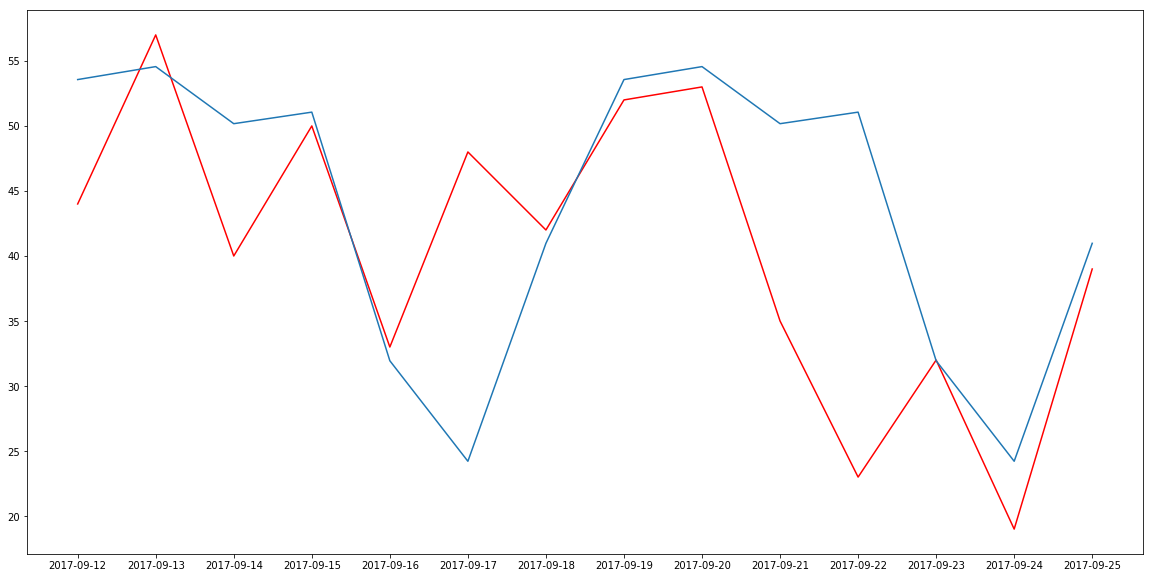

In [222]:
plt.figure(figsize=(20, 10))
total_idx = np.flatnonzero((test_feat.SCOPE == 'ALL') & (test_feat.BLD_GROUP_CODE == 1))

plt.plot(test_feat['DATE'][total_idx], np.exp(test_feat['UNITS'][total_idx]) - 1, 'r')
plt.plot(test_feat['DATE'][total_idx], np.exp(pred[total_idx]) - 1)

In [172]:
val_err = [0.481106, 0.629508, 0.508958, 1.15894, 0.840258]
test_err = [0.544899, 0.5804749029223979, 0.5730903051579546, 1.054261871333747, 0.7502473688303578]

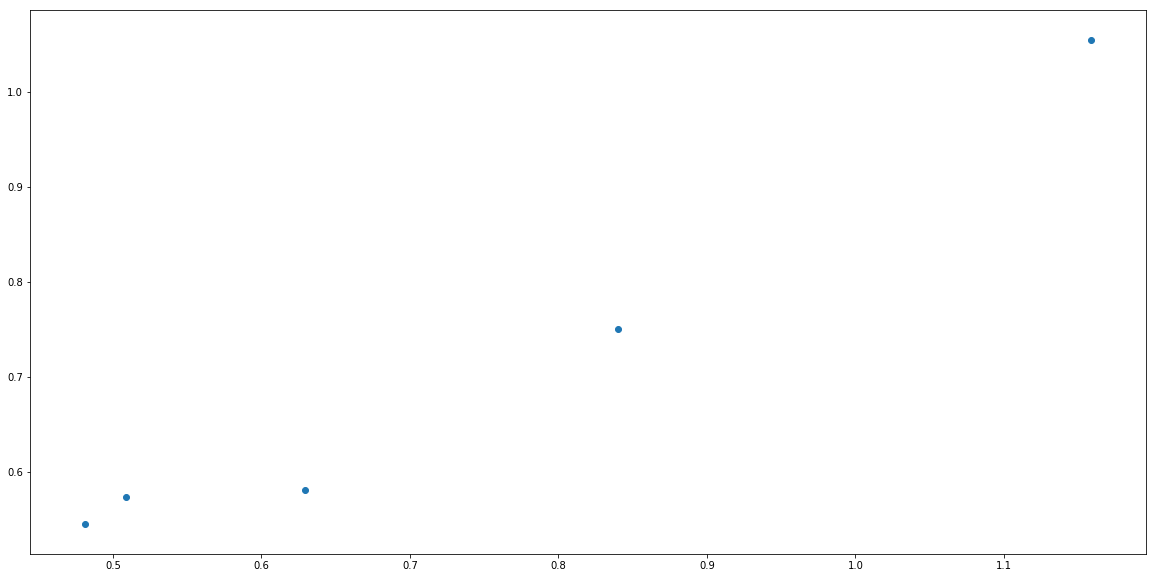

In [173]:
plt.figure(figsize=(20, 10))
plt.scatter(val_err, test_err)

## Viz

In [260]:
from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [315]:
def show_result(trn_x, trn_y, trn_p, valid_x, valid_y, valid_p, title):
    plt.figure(figsize=(20, 10))
    plt.plot(trn_x, trn_y, 'k-.')
    plt.plot(valid_x, valid_y, 'k-.')
    
    plt.plot(trn_x, trn_p, 'b-*')
    plt.plot(valid_x, valid_p, 'g-*')

In [253]:
train_feat = pd.read_feather(f'{PATH}train_feat')
val_feat = pd.read_feather(f'{PATH}val_fest')

In [254]:
predictors = [f for f in train_feat.columns if f not in (['index','DATE','end_date'])]

In [256]:
cat_vars = ['SCOPE', 'BLD_GROUP_CODE', 'dow', 'dom', 'month', 'year', 'hol3', 'hol7', 'holw',
           'ahead_hol3_3','diff_of_day',
 'ahead_hol7_3',
 'ahead_holw_3',
 'ahead_hol3_2',
 'ahead_hol7_2',
 'ahead_holw_2',
 'ahead_hol3_1',
 'ahead_hol7_1',
 'ahead_holw_1',
 'ahead_hol3_-1',
 'ahead_hol7_-1',
 'ahead_holw_-1'
           ]
for v in cat_vars:
    train_feat[v] = train_feat[v].astype('category').cat.as_ordered()
apply_cats(val_feat, train_feat)

df, y, nas, mapper = proc_df(train_feat[predictors], 'UNITS', do_scale=True)
df_val, y_val, _, _ = proc_df(val_feat[predictors], 'UNITS', do_scale=True, mapper=mapper, na_dict=nas)

In [257]:
X_train, X_valid = df, df_val
y_train, y_valid = np.log1p(y), np.log1p(y_val)

In [258]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

### RF

In [316]:
m = RandomForestRegressor(n_estimators=100, min_samples_leaf=100, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.411808245121531, 0.4204738711180523, 0.94876306660191068, 0.94081352116177963, 0.94529163970229502]


In [320]:
trn_p = m.predict(X_train)
valid_p = m.predict(X_valid)

### lgb

In [ ]:

lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_valid, y_valid)

In [286]:
evals_result = {}
params = {
    'learning_rate': 0.1,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'sub_feature': 0.2,
    'num_leaves': 500,
    'min_data': 300,
#     'min_hessian': 1,
    'verbose': -1,
}
gbm = lgb.train(params,
                lgb_train, 
                valid_sets=(lgb_train, lgb_val), 
                num_boost_round=40,
                evals_result=evals_result)

[1]	training's rmse: 1.64908	valid_1's rmse: 1.56476
[2]	training's rmse: 1.49677	valid_1's rmse: 1.41404
[3]	training's rmse: 1.36037	valid_1's rmse: 1.27914
[4]	training's rmse: 1.23911	valid_1's rmse: 1.15943
[5]	training's rmse: 1.13129	valid_1's rmse: 1.05495
[6]	training's rmse: 1.03566	valid_1's rmse: 0.962343
[7]	training's rmse: 0.950796	valid_1's rmse: 0.880858
[8]	training's rmse: 0.875874	valid_1's rmse: 0.807624
[9]	training's rmse: 0.809955	valid_1's rmse: 0.744475
[10]	training's rmse: 0.75262	valid_1's rmse: 0.689496
[11]	training's rmse: 0.702391	valid_1's rmse: 0.643544
[12]	training's rmse: 0.658773	valid_1's rmse: 0.604488
[13]	training's rmse: 0.621031	valid_1's rmse: 0.571173
[14]	training's rmse: 0.588536	valid_1's rmse: 0.541792
[15]	training's rmse: 0.560587	valid_1's rmse: 0.517624
[16]	training's rmse: 0.536587	valid_1's rmse: 0.497456
[17]	training's rmse: 0.516545	valid_1's rmse: 0.481384
[18]	training's rmse: 0.499337	valid_1's rmse: 0.468447
[19]	training

### DL

In [287]:
md = ColumnarModelData.from_data_frames(PATH, X_train, X_valid, y_train, y_valid, cat_flds=cat_vars, bs=32)

In [299]:
max_log_y = np.max(np.concatenate([y_train, y_valid]))
y_range = (0, max_log_y*1.2)

In [290]:
for v in cat_vars: X_train[v] = X_train[v].astype('category').cat.as_ordered()
for v in cat_vars: X_valid[v] = X_valid[v].astype('category').cat.as_ordered()

In [295]:
joined = pd.concat([X_train, X_valid])
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [296]:
cat_sz = [(c, len(joined[c].cat.categories)+1) for c in cat_vars]

In [297]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [306]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [300, 150], [0.01, 0.01], y_range=y_range, use_bn=True)
lr = 1e-3

In [307]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 64%|██████▍   | 1217/1894 [00:13<00:07, 91.82it/s, loss=0.891]

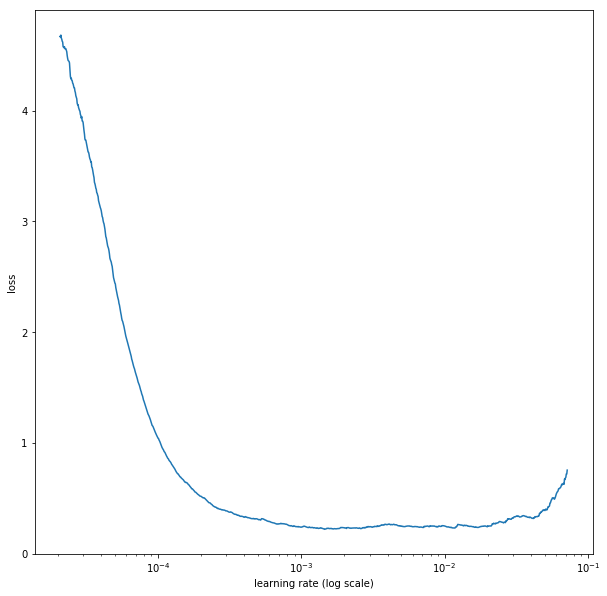

In [308]:
rcParams['figure.figsize'] = 10, 10
m.sched.plot(100)

In [309]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [300, 150], [0.01, 0.01], y_range=y_range, use_bn=True)
lr = 1e-4

In [310]:
%time m.fit(lr, 3, metrics=[rmse])

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))


  5%|▌         | 104/1894 [00:01<00:33, 53.57it/s, loss=1.18]


 12%|█▏        | 221/1894 [00:03<00:24, 68.08it/s, loss=0.461]


 17%|█▋        | 329/1894 [00:04<00:21, 71.38it/s, loss=0.32] 


 23%|██▎       | 439/1894 [00:05<00:19, 74.41it/s, loss=0.273]


 29%|██▉       | 550/1894 [00:07<00:17, 76.49it/s, loss=0.244]


 31%|███       | 586/1894 [00:07<00:16, 77.64it/s, loss=0.246]

 31%|███▏      | 595/1894 [00:07<00:16, 76.80it/s, loss=0.244] [A

Exception in thread Thread-44:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Exception in thread Thread-45:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.p

[ 0.       0.20082  0.20723  0.4491 ]                          
[ 1.       0.18352  0.19417  0.4344 ]                          
[ 2.       0.19226  0.20377  0.44522]                          

CPU times: user 57.4 s, sys: 7.47 s, total: 1min 4s
Wall time: 59.4 s


In [313]:
m.fit(lr, 3, metrics=[rmse], cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.17314  0.18532  0.42344]                          
[ 1.       0.17584  0.18771  0.42536]                          
[ 2.       0.17602  0.18699  0.42508]                          
[ 3.       0.18175  0.18656  0.42442]                          
[ 4.       0.17143  0.18216  0.41964]                          
[ 5.       0.16171  0.18697  0.42451]                          
[ 6.       0.167    0.18512  0.42269]                          

